In [1]:
import torch
import numpy as np
import mdtraj

import sys
sys.path.insert(1, '/var/home/vs488/Documents/boltzmann/code/boltzmann-generators/')
import boltzgen.zmatrix as zmatrix
import boltzgen.internal as ics
import boltzgen.mixed as mixed

import normflow as nf
from boltzgen.flows import CoordinateTransform
from boltzgen.distributions import Boltzmann

from tqdm import tqdm
from matplotlib import pyplot as plt

from autograd import grad
from autograd import numpy as np
from openmmtools.constants import kB
from simtk import openmm as mm
from simtk import unit
from simtk.openmm import app
from openmmtools.testsystems import AlanineDipeptideImplicit

import sys
sys.path.insert(1, '/var/home/vs488/Documents/boltzmann/code/boltzmann-generators/')
import boltzgen.openmm_interface as omi

# Load the alanine dipeptide trajectory
aldp_traj = mdtraj.load('/scratch2/vs488/flow/alanine_dipeptide/trajectory/aldp10000.h5')

In [2]:
# Set up coordinate transformation

z_matrix = [
    (1, [4, 5, 6]),
    (0, [1, 4, 5]),
    (2, [1, 0, 4]),
    (3, [1, 0, 2]),
    (7, [6, 4, 5]),
    (9, [8, 6, 7]),
    (10, [8, 6, 9]),
    (11, [10, 8, 9]),
    (12, [10, 8, 11]),
    (13, [10, 11, 12]),
    (17, [16, 14, 15]),
    (19, [18, 16, 17]),
    (20, [18, 19, 16]),
    (21, [18, 19, 20])
]

backbone_indices = [4, 5, 6, 8, 14, 15, 16, 18]

aldp_traj.center_coordinates()

# superpose on the backbone
ind = aldp_traj.top.select("backbone")

aldp_traj.superpose(aldp_traj, 0, atom_indices=ind, ref_atom_indices=ind)

# Gather the training data into a pytorch Tensor with the right shape
training_data = aldp_traj.xyz
n_atoms = training_data.shape[1]
n_dim = n_atoms * 3
training_data_npy = training_data.reshape(-1, n_dim)
training_data = torch.from_numpy(training_data_npy.astype("float32"))

# This performs the mixed transform
# The z index matrix atoms are transformed to internal coordinates
# The cartesian atoms just have PCA applied to them
mixed_transform = mixed.MixedTransform(66, backbone_indices, z_matrix, training_data)

# Test the forward and backward pass
mixed_coords, jac = mixed_transform.forward(training_data)
orig_coords, invjac = mixed_transform.inverse(mixed_coords)

In [3]:
# Set up simulation object for energy computation

temperature = 298
kT = kB * temperature

testsystem = AlanineDipeptideImplicit()
implicit_sim = app.Simulation(testsystem.topology,
                              testsystem.system,
                              mm.LangevinIntegrator(temperature * unit.kelvin , 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                              platform=mm.Platform.getPlatformByName('CPU')
                              )
implicit_sim.context.setPositions(testsystem.positions)

# Energy function
openmm_energy = omi.OpenMMEnergyInterface.apply

In [4]:
# Set up flow model

# Define flows
K = 8
#torch.manual_seed(0)

latent_size = 60
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size])
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size])
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, s, t)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, s, t)]
flows += [CoordinateTransform(training_data, 66, z_matrix, backbone_indices)]

# Set prior and q0
prior = Boltzmann(implicit_sim.context, temperature)
q0 = nf.distributions.DiagGaussian(latent_size)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=prior)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

In [5]:
# Train model
max_iter = 1000
batch_size = 64
num_samples = 2 * 15
n_data = len(training_data)


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-5, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    ind = torch.randint(n_data, (batch_size, ))
    x = training_data[ind, :].double()
    loss = nfm.forward_kld(x) #+ nfm.reverse_kld(num_samples=batch_size)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

100%|██████████| 1000/1000 [00:19<00:00, 50.93it/s]


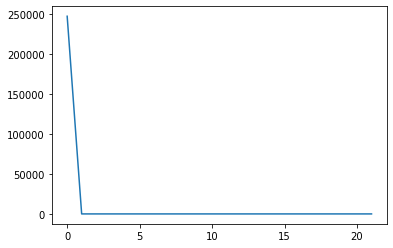

In [6]:
plt.plot(loss_hist)

In [10]:
prior.log_prob(torch.randn(10, 66))

tensor([[-2082.1267],
        [-1556.9872],
        [-1586.7352],
        [ -723.6367],
        [-1453.6923],
        [-2459.8137],
        [-1034.8506],
        [-1350.1493],
        [-2028.2798],
        [-1275.2727]])